In [2]:

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from autots import AutoTS
import pathlib
import json


from scipy.interpolate import griddata as gd

from pykrige.ok import OrdinaryKriging

import matplotlib.animation as animation
from matplotlib import cm

In [3]:
from mpl_toolkits import mplot3d

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
gelman_data = pd.read_excel("../../result(new)/joined_well_data.xlsx")
gelman_data.head(5)

,Unnamed: 0,Bore,Name,Depth1,Depth2,SampleDate,Value,Comment,Enabled,Easting,...,utm_datum,utm_zone,utm_x,utm_y,utm_unit,pj4_x,pj4_y,pj4_paramstr,lat,lon
0,0,1021 Westview Way,1-4 Dioxane,260.0,268.0,2019-05-08,0.5,EGLE Lab,False,13274717.9,...,22,12,0,0,1,0,0,NaN,42.269732,-83.807344
1,1,1024 Westview Way,1-4 Dioxane,-9999.0,-9999.0,2019-05-08,0.5,EGLE Lab,False,13274221.6,...,22,12,0,0,1,0,0,NaN,42.269808,-83.809177
2,2,1049 Westview Way,1-4 Dioxane,272.0,280.0,2019-05-08,0.5,EGLE Lab,False,13274722.1,...,22,12,0,0,1,0,0,NaN,42.269390,-83.807331
3,3,105 Myrtle,1-4 Dioxane,61.0,65.0,1999-03-27,0.5,NaN,False,13269250.0,...,22,12,0,0,1,0,0,NaN,42.285462,-83.827411
4,4,105 Myrtle,1-4 Dioxane,61.0,65.0,1999-05-28,0.5,NaN,False,13269250.0,...,22,12,0,0,1,0,0,NaN,42.285462,-83.827411


In [6]:
aquifer_data = pd.read_excel('../../data/Gelman_2020_DATA_Rockworks6-2020.xlsx',
                          sheet_name = 'Aquifer')
aquifer_data.head(5)

,Bore,Depth1,Depth2,Aquifer Name,SampleDate,Comment
0,110 Parkland Plaza,53.60,53.60,Aquifer Combined,1999-08-09,NaN
1,110 Parkland Plaza,53.56,53.56,Aquifer Combined,1999-08-19,NaN
2,110 Parkland Plaza,54.15,54.15,Aquifer Combined,1999-11-12,NaN
3,110 Parkland Plaza,54.55,54.55,Aquifer Combined,2000-02-15,NaN
4,110 Parkland Plaza,54.60,54.60,Aquifer Combined,2000-06-07,NaN


In [7]:
def get_aquifer(well_name):
    d =aquifer_data[aquifer_data['Bore'] == well_name]
    return d['Depth1'].mean()

get_aquifer('110 Parkland Plaza')

55.634477611940305

[-114.6062162162162, -94.78399999999999, -83.81634146341464, -83.67743243243244, -78.34471698113207, -77.81827956989248, -77.31204081632653, -76.74545454545455, -76.25681818181819, -75.45949999999999, -75.02174825174826, -74.97098591549296, -73.7446511627907, -73.51647887323945, -73.27468085106382, -73.14408163265306, -72.72200000000001, -72.49102362204725, -72.34476190476191, -72.26953125, -71.86489361702128, -71.58630573248408, -71.52148148148149, -71.385, -70.17136363636362, -70.17107843137255, -70.16272727272728, -69.9843181818182, -69.94779661016948, -69.89339805825243, -69.76492063492064, -69.65047619047618, -68.80508620689653, -68.0371, -67.902890625, -67.8221138211382, -66.815, -66.59575757575759, -66.45425925925927, -65.99163636363636, -65.84439393939395, -64.705, -64.60942857142857, -64.37876923076922, -64.31297029702971, -63.34860759493671, -63.09297297297299, -62.98986486486486, -62.87887931034483, -62.53943661971831, -60.98935483870968, -60.61, -60.30008333333333, -59.6789

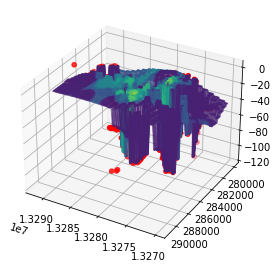

In [23]:
extrapolation_interval = 30

interpolationmethod = 'nearest'

def extract_by_date(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31)):
    zdata = []
    val_data = []
    xdata = []
    ydata = []

    grouped = gelman_data.groupby('Bore')
    count = 0
    for name, group in grouped:
        count += 1

        group.loc[:, 'ds'] = pd.to_datetime(group['SampleDate'])
        tmp = []
        for index, row in group.iterrows():
            ds = row['ds']
            e = row['Easting']
            if start_date <= ds <= end_date and e > 13270000:
                tmp.append(row)
        df = pd.DataFrame(tmp)
        if len(tmp) > 0:
            mean_value = df["Value"].mean()
            xdata.append(pd.to_numeric(df['Easting'],errors ='ignore').iloc[0])
            ydata.append(pd.to_numeric(df['Northing'],errors ='ignore').iloc[0])
            # depth = pd.to_numeric(df['Depth1'],errors ='ignore').iloc[0]
            aquifer = get_aquifer(name)
            if np.isnan(aquifer):
                aquifer = 0
            # if depth < 0 or depth > 1000:
            #     depth = 0
            zdata.append(-aquifer)
            val_data.append(mean_value)
    return xdata, ydata, zdata, val_data

def get_ztop(xdata, ydata, zdata):
    t = []
    for i in range(len(xdata)):
        tmp = [xdata[i], ydata[i], zdata[i]]
        t.append(tmp)
    top = np.asarray(t)
    t.clear()
    return top

def interpolation(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method=interpolationmethod, rescale=True)
    return grid_x, grid_y, grid_z

def interpolationValue(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def nearest_neighbor_interpolation(data, x, y, p=0.5):
    """
    Nearest Neighbor Weighted Interpolation
    http://paulbourke.net/miscellaneous/interpolation/
    http://en.wikipedia.org/wiki/Inverse_distance_weighting

    :param data: numpy.ndarray
        [[float, float, float], ...]
    :param p: float=0.5
        importance of distant samples
    :return: interpolated data
    """
    n = len(data)
    vals = np.zeros((n, 2), dtype=np.float64)
    distance = lambda x1, x2, y1, y2: (x2 - x1)**2 + (y2 - y1)**2
    for i in range(n):
        vals[i, 0] = data[i, 2] / (distance(data[i, 0], x, data[i, 1], y))**p
        vals[i, 1] = 1          / (distance(data[i, 0], x, data[i, 1], y))**p
    z = np.sum(vals[:, 0]) / np.sum(vals[:, 1])
    return z

def extrapolation(data, extrapolation_spots,  xrange, yrange,method='nearest'):
    if method == 'kriging':
        xx, yy, zz, ss = kriging(data, xrange, yrange)

        new_points = np.zeros((len(yy) * len(zz), 3))
        count = 0
        for i in range(len(xx)):
            for j in range(len(yy)):
                new_points[count, 0] = xx[i]
                new_points[count, 1] = yy[j]
                new_points[count, 2] = zz[i, j]
                count += 1
        combined = np.concatenate((data, new_points))
        return combined

    if method == 'nearest':
        new_points = np.zeros((len(extrapolation_spots), 3))
        new_points[:, 0] = extrapolation_spots[:, 0]
        new_points[:, 1] = extrapolation_spots[:, 1]
        for i in range(len(extrapolation_spots)):
            new_points[i, 2] = nearest_neighbor_interpolation(data,
                                    extrapolation_spots[i, 0],
                                    extrapolation_spots[i, 1], p=4)
        combined = np.concatenate((data, new_points))
        return combined

def kriging(k_data, xrange, yrange):
    # 13270000.0 - 13290000.0
    # grid_x = np.arange(xrange[0], xrange[1], 500)
    # 283000.0 - 287000.0
    # grid_y = np.arange(yrange[0], yrange[1], 200)

    grid_x = np.arange(xrange[0], xrange[1], 1000)

    grid_y = np.arange(yrange[0], yrange[1], 500)
    OK = OrdinaryKriging(k_data[:, 0], k_data[:, 1], k_data[:, 2], variogram_model='linear',
                                 verbose=False)

    z_res, ss = OK.execute('grid', grid_x, grid_y)
    return grid_x, grid_y, z_res, ss

def kriging_analysis(extrapolation_spots_t, top, value_top, scatter, debug, xrange, yrange):
    top_extra = extrapolation(top, extrapolation_spots_t,  xrange, yrange, method='kriging')

    print(top_extra)

    gridx_top, gridy_top, gridz_top = interpolation(top_extra, xrange, yrange)

    print(type(gridz_top))

    print(gridz_top)

    top_value_extra = extrapolation(value_top, extrapolation_spots_t, xrange, yrange, method='nearest')
    gridx_v_top, gridy_v_top, gridz_v_top = interpolationValue(top_value_extra, xrange, yrange)
    # gridz_v_top = gridz_top

    plot(top, gridx_top, gridy_top, gridz_top, gridz_v_top ,method='snaps',
            title='_top_kriging', scatter = scatter, debug = debug)

def plot(data, gridx, gridy, gridz, grid_value_z, method='rotate', title='nearest', both=False,
         scatter = True, debug = False):
    fig = plt.figure(figsize=(10, 10))
    angles = [45, 120, 220, 310]

    for i in range(1, 2):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        gridz_ = np.nan_to_num(gridz)

        grid_value_z = np.nan_to_num(grid_value_z)

        if debug:
            print(grid_value_z)
            print(grid_value_z.min())
            print(grid_value_z.max())

        bounds = [grid_value_z.min(), 0,4,
                  7.2,85,
                  150,280,500,
                  1000,1900,3000,5000, grid_value_z.max()]
        norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        # norm = matplotlib.colors.LogNorm(grid_value_z.min(), grid_value_z.max())
        colors = cm.viridis(norm(grid_value_z))
        rcount, ccount, _ = colors.shape


        ax.plot_surface(gridx, gridy, gridz_,
                   rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False, alpha = 0.5)

        # ax.plot_wireframe(gridx, gridy, gridz_, alpha=0.5)

        if scatter:
            ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
        ax.view_init(azim=angles[i])

    plt.savefig('snaps_{}.png'.format(title))

def get_plane(xl, xu, yl, yu, i):
    xx = np.arange(xl, xu, i)
    yy = np.arange(yl, yu, i)
    extrapolation_spots_res = np.zeros((len(xx) * len(yy), 2))
    count = 0
    for i in xx:
        for j in yy:
            extrapolation_spots_res[count, 0] = i
            extrapolation_spots_res[count, 1] = j
            count += 1
    return extrapolation_spots_res

def main(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31),
         xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0),
         scatter = True, debug = False):
    xdata,ydata,zdata,val_data = extract_by_date(start_date, end_date)
    zdata.sort()
    print(zdata)
    extrapolation_spots = get_plane(xrange[0], xrange[1], yrange[0], yrange[1], extrapolation_interval)

    top = get_ztop(xdata, ydata, zdata)
    value_top = get_ztop(xdata, ydata, val_data)

    kriging_analysis(extrapolation_spots, top, value_top, scatter, debug, xrange, yrange)


main(datetime.datetime(2016, 1, 1), datetime.datetime(2021, 12, 31), xrange = (13270000.0, 13290000.0),
         yrange = (280000.0, 290000.0), scatter = True, debug = False)

[-114.6062162162162, -94.78399999999999, -83.81634146341464, -83.67743243243244, -78.34471698113207, -77.81827956989248, -77.31204081632653, -76.74545454545455, -76.25681818181819, -75.45949999999999, -75.02174825174826, -74.97098591549296, -73.7446511627907, -73.51647887323945, -73.27468085106382, -73.14408163265306, -72.72200000000001, -72.49102362204725, -72.34476190476191, -72.26953125, -71.86489361702128, -71.58630573248408, -71.52148148148149, -71.385, -70.17136363636362, -70.17107843137255, -70.16272727272728, -69.9843181818182, -69.94779661016948, -69.89339805825243, -69.76492063492064, -69.65047619047618, -68.80508620689653, -68.0371, -67.902890625, -67.8221138211382, -66.815, -66.59575757575759, -66.45425925925927, -65.99163636363636, -65.84439393939395, -64.705, -64.60942857142857, -64.37876923076922, -64.31297029702971, -63.34860759493671, -63.09297297297299, -62.98986486486486, -62.87887931034483, -62.53943661971831, -60.98935483870968, -60.61, -60.30008333333333, -59.6789

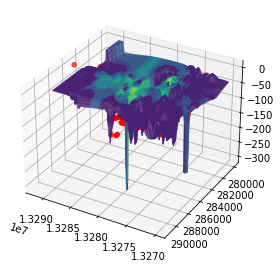

In [24]:
extrapolation_interval = 30

interpolationmethod = 'nearest'

def get_ztop(xdata, ydata, zdata):
    t = []
    for i in range(len(xdata)):
        tmp = [xdata[i], ydata[i], zdata[i]]
        t.append(tmp)
    top = np.asarray(t)
    t.clear()
    return top

def interpolation(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def interpolationValue(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def nearest_neighbor_interpolation(data, x, y, p=0.5):
    """
    Nearest Neighbor Weighted Interpolation
    http://paulbourke.net/miscellaneous/interpolation/
    http://en.wikipedia.org/wiki/Inverse_distance_weighting

    :param data: numpy.ndarray
        [[float, float, float], ...]
    :param p: float=0.5
        importance of distant samples
    :return: interpolated data
    """
    n = len(data)
    vals = np.zeros((n, 2), dtype=np.float64)
    distance = lambda x1, x2, y1, y2: (x2 - x1)**2 + (y2 - y1)**2
    for i in range(n):
        vals[i, 0] = data[i, 2] / (distance(data[i, 0], x, data[i, 1], y))**p
        vals[i, 1] = 1          / (distance(data[i, 0], x, data[i, 1], y))**p
    z = np.sum(vals[:, 0]) / np.sum(vals[:, 1])
    return z

def extrapolation(data, extrapolation_spots,  xrange, yrange,method='nearest'):
    if method == 'kriging':
        xx, yy, zz, ss = kriging(data, xrange, yrange)

        new_points = np.zeros((len(yy) * len(zz), 3))
        count = 0
        for i in range(len(xx)):
            for j in range(len(yy)):
                new_points[count, 0] = xx[i]
                new_points[count, 1] = yy[j]
                new_points[count, 2] = zz[i, j]
                count += 1
        combined = np.concatenate((data, new_points))
        return combined

    if method == 'nearest':
        new_points = np.zeros((len(extrapolation_spots), 3))
        new_points[:, 0] = extrapolation_spots[:, 0]
        new_points[:, 1] = extrapolation_spots[:, 1]
        for i in range(len(extrapolation_spots)):
            new_points[i, 2] = nearest_neighbor_interpolation(data,
                                    extrapolation_spots[i, 0],
                                    extrapolation_spots[i, 1], p=4)
        combined = np.concatenate((data, new_points))
        return combined

def kriging(k_data, xrange, yrange):
    # 13270000.0 - 13290000.0
    # grid_x = np.arange(xrange[0], xrange[1], 500)
    # 283000.0 - 287000.0
    # grid_y = np.arange(yrange[0], yrange[1], 200)

    grid_x = np.arange(xrange[0], xrange[1], 1000)

    grid_y = np.arange(yrange[0], yrange[1], 500)
    OK = OrdinaryKriging(k_data[:, 0], k_data[:, 1], k_data[:, 2], variogram_model='linear',
                                 verbose=False)

    z_res, ss = OK.execute('grid', grid_x, grid_y)
    return grid_x, grid_y, z_res, ss

def kriging_analysis(extrapolation_spots_t, top, value_top, scatter, debug, xrange, yrange):
    top_extra = extrapolation(top, extrapolation_spots_t,  xrange, yrange, method='kriging')

    print(top_extra)

    gridx_top, gridy_top, gridz_top_tmp = interpolation(top_extra, xrange, yrange)

    gridz_top = gridz_top_tmp[:]
    gridz_top[gridz_top > 0] = 0
    gridz_top[gridz_top < -300] = -300

    top_value_extra = extrapolation(value_top, extrapolation_spots_t, xrange, yrange, method='nearest')
    gridx_v_top, gridy_v_top, gridz_v_top = interpolationValue(top_value_extra, xrange, yrange)
    # gridz_v_top = gridz_top

    plot(top, gridx_top, gridy_top, gridz_top, gridz_v_top ,method='snaps',
            title='_top_kriging', scatter = scatter, debug = debug)

def plot(data, gridx, gridy, gridz, grid_value_z, method='rotate', title='nearest', both=False,
         scatter = True, debug = False):
    fig = plt.figure(figsize=(10, 10))
    angles = [45, 120, 220, 310]

    for i in range(1, 2):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        gridz_ = np.nan_to_num(gridz)

        grid_value_z = np.nan_to_num(grid_value_z)

        if debug:
            print(grid_value_z)
            print(grid_value_z.min())
            print(grid_value_z.max())

        bounds = [grid_value_z.min(), 0,4,
                  7.2,85,
                  150,280,500,
                  1000,1900,3000,5000, grid_value_z.max()]
        norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        # norm = matplotlib.colors.LogNorm(grid_value_z.min(), grid_value_z.max())
        colors = cm.viridis(norm(grid_value_z))
        rcount, ccount, _ = colors.shape


        ax.plot_surface(gridx, gridy, gridz_,
                   rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False, alpha = 0.5)

        # ax.plot_wireframe(gridx, gridy, gridz_, alpha=0.5)

        if scatter:
            ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
        ax.view_init(azim=angles[i])

    plt.savefig('snaps_{}.png'.format(title))

def get_plane(xl, xu, yl, yu, i):
    xx = np.arange(xl, xu, i)
    yy = np.arange(yl, yu, i)
    extrapolation_spots_res = np.zeros((len(xx) * len(yy), 2))
    count = 0
    for i in xx:
        for j in yy:
            extrapolation_spots_res[count, 0] = i
            extrapolation_spots_res[count, 1] = j
            count += 1
    return extrapolation_spots_res

def main(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31),
         xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0),
         scatter = True, debug = False):
    xdata,ydata,zdata,val_data = extract_by_date(start_date, end_date)
    zdata.sort()
    print(zdata)
    extrapolation_spots = get_plane(xrange[0], xrange[1], yrange[0], yrange[1], extrapolation_interval)

    top = get_ztop(xdata, ydata, zdata)
    value_top = get_ztop(xdata, ydata, val_data)

    kriging_analysis(extrapolation_spots, top, value_top, scatter, debug, xrange, yrange)

main(datetime.datetime(2016, 1, 1), datetime.datetime(2021, 12, 31), xrange = (13270000.0, 13290000.0),
         yrange = (280000.0, 290000.0), scatter = True, debug = False)

In [22]:
extrapolation_interval = 30

interpolationmethod = 'cubic'

def extract_by_date(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31)):
    zdata = []
    val_data = []
    xdata = []
    ydata = []

    grouped = gelman_data.groupby('Bore')
    count = 0
    for name, group in grouped:
        count += 1

        group.loc[:, 'ds'] = pd.to_datetime(group['SampleDate'])
        tmp = []
        for index, row in group.iterrows():
            ds = row['ds']
            e = row['Easting']
            if start_date <= ds <= end_date and e > 13270000:
                tmp.append(row)
        df = pd.DataFrame(tmp)
        if len(tmp) > 0:
            mean_value = df["Value"].mean()
            xdata.append(pd.to_numeric(df['Easting'],errors ='ignore').iloc[0])
            ydata.append(pd.to_numeric(df['Northing'],errors ='ignore').iloc[0])
            depth = pd.to_numeric(df['Depth1'],errors ='ignore').iloc[0]
            aquifer = get_aquifer(name)
            if np.isnan(aquifer):
                aquifer = 0
            if depth < 0 or depth > 1000:
                depth = 0
            zdata.append(-depth)
            val_data.append(mean_value)
    return xdata, ydata, zdata, val_data

def get_ztop(xdata, ydata, zdata):
    t = []
    for i in range(len(xdata)):
        tmp = [xdata[i], ydata[i], zdata[i]]
        t.append(tmp)
    top = np.asarray(t)
    t.clear()
    return top

def interpolation(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:500j, yrange[0]:yrange[1]:500j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method=interpolationmethod, rescale=True)
    return grid_x, grid_y, grid_z

def interpolationValue(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:500j, yrange[0]:yrange[1]:500j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def nearest_neighbor_interpolation(data, x, y, p=0.5):
    """
    Nearest Neighbor Weighted Interpolation
    http://paulbourke.net/miscellaneous/interpolation/
    http://en.wikipedia.org/wiki/Inverse_distance_weighting

    :param data: numpy.ndarray
        [[float, float, float], ...]
    :param p: float=0.5
        importance of distant samples
    :return: interpolated data
    """
    n = len(data)
    vals = np.zeros((n, 2), dtype=np.float64)
    distance = lambda x1, x2, y1, y2: (x2 - x1)**2 + (y2 - y1)**2
    for i in range(n):
        vals[i, 0] = data[i, 2] / (distance(data[i, 0], x, data[i, 1], y))**p
        vals[i, 1] = 1          / (distance(data[i, 0], x, data[i, 1], y))**p
    z = np.sum(vals[:, 0]) / np.sum(vals[:, 1])
    return z

def extrapolation(data, extrapolation_spots,  xrange, yrange,method='nearest'):
    if method == 'kriging':
        xx, yy, zz, ss = kriging(data, xrange, yrange)

        new_points = np.zeros((len(yy) * len(zz), 3))
        count = 0
        for i in range(len(xx)):
            for j in range(len(yy)):
                new_points[count, 0] = xx[i]
                new_points[count, 1] = yy[j]
                new_points[count, 2] = zz[i, j]
                count += 1
        combined = np.concatenate((data, new_points))
        return combined

    if method == 'nearest':
        new_points = np.zeros((len(extrapolation_spots), 3))
        new_points[:, 0] = extrapolation_spots[:, 0]
        new_points[:, 1] = extrapolation_spots[:, 1]
        for i in range(len(extrapolation_spots)):
            new_points[i, 2] = nearest_neighbor_interpolation(data,
                                    extrapolation_spots[i, 0],
                                    extrapolation_spots[i, 1], p=4)
        combined = np.concatenate((data, new_points))
        return combined

def kriging(k_data, xrange, yrange):
    # 13270000.0 - 13290000.0
    grid_x = np.arange(xrange[0], xrange[1], 500)
    # 283000.0 - 287000.0
    grid_y = np.arange(yrange[0], yrange[1], 200)

    # grid_x = np.arange(xrange[0], xrange[1], 1000)
    #
    # grid_y = np.arange(yrange[0], yrange[1], 500)
    OK = OrdinaryKriging(k_data[:, 0], k_data[:, 1], k_data[:, 2], variogram_model='spherical',
                             verbose=False, nlags=100)

    z_res, ss = OK.execute('grid', grid_x, grid_y)
    return grid_x, grid_y, z_res, ss

def kriging_analysis(extrapolation_spots_t, top, value_top, scatter, debug, xrange, yrange):
    top_extra = extrapolation(top, extrapolation_spots_t,  xrange, yrange, method='kriging')

    print(top_extra)

    gridx_top, gridy_top, gridz_top_tmp = interpolation(top_extra, xrange, yrange)

    print(type(gridz_top_tmp))

    print(gridz_top_tmp)

    gridz_top = gridz_top_tmp[:]
    gridz_top[gridz_top > 0] = 0
    gridz_top[gridz_top < -150] = -150

    top_value_extra = extrapolation(value_top, extrapolation_spots_t, xrange, yrange, method='nearest')
    gridx_v_top, gridy_v_top, gridz_v_top = interpolationValue(top_value_extra, xrange, yrange)
    # gridz_v_top = gridz_top

    plot(top, gridx_top, gridy_top, gridz_top, gridz_v_top ,method='snaps',
            title='_top_kriging', scatter = scatter, debug = debug)

def plot(data, gridx, gridy, gridz, grid_value_z, method='rotate', title='nearest', both=False,
         scatter = True, debug = False):
    fig = plt.figure(figsize=(10, 10))
    angles = [45, 120, 220, 310]

    for i in range(1, 4):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        gridz_ = np.nan_to_num(gridz)

        grid_value_z = np.nan_to_num(grid_value_z)

        if debug:
            print(grid_value_z)
            print(grid_value_z.min())
            print(grid_value_z.max())

        bounds = [grid_value_z.min(), 0,4,
                  7.2,85,
                  150,280,500,
                  1000,1900,3000,5000, grid_value_z.max()]
        norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        # norm = matplotlib.colors.LogNorm(grid_value_z.min(), grid_value_z.max())
        colors = cm.viridis(norm(grid_value_z))
        rcount, ccount, _ = colors.shape


        ax.plot_surface(gridx, gridy, gridz_,
                   rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False, alpha = 0.5)

        # ax.plot_wireframe(gridx, gridy, gridz_, alpha=0.5)

        if scatter:
            ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
        ax.view_init(azim=angles[i])

    plt.savefig('snaps_{}.png'.format(title))

def get_plane(xl, xu, yl, yu, i):
    xx = np.arange(xl, xu, i)
    yy = np.arange(yl, yu, i)
    extrapolation_spots_res = np.zeros((len(xx) * len(yy), 2))
    count = 0
    for i in xx:
        for j in yy:
            extrapolation_spots_res[count, 0] = i
            extrapolation_spots_res[count, 1] = j
            count += 1
    return extrapolation_spots_res

def main(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31),
         xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0),
         scatter = True, debug = False):
    xdata,ydata,zdata,val_data = extract_by_date(start_date, end_date)
    zdata.sort()
    print(zdata)
    extrapolation_spots = get_plane(xrange[0], xrange[1], yrange[0], yrange[1], extrapolation_interval)

    top = get_ztop(xdata, ydata, zdata)
    value_top = get_ztop(xdata, ydata, val_data)

    kriging_analysis(extrapolation_spots, top, value_top, scatter, debug, xrange, yrange)

[-114.6062162162162, -94.78399999999999, -83.81634146341464, -83.67743243243244, -78.34471698113207, -77.81827956989248, -77.31204081632653, -76.74545454545455, -76.25681818181819, -75.45949999999999, -75.02174825174826, -74.97098591549296, -73.7446511627907, -73.51647887323945, -73.27468085106382, -73.14408163265306, -72.72200000000001, -72.49102362204725, -72.34476190476191, -72.26953125, -71.86489361702128, -71.58630573248408, -71.52148148148149, -71.385, -70.17136363636362, -70.17107843137255, -70.16272727272728, -69.9843181818182, -69.94779661016948, -69.89339805825243, -69.76492063492064, -69.65047619047618, -68.80508620689653, -68.0371, -67.902890625, -67.8221138211382, -66.815, -66.59575757575759, -66.45425925925927, -65.99163636363636, -65.84439393939395, -64.705, -64.60942857142857, -64.37876923076922, -64.31297029702971, -63.34860759493671, -63.09297297297299, -62.98986486486486, -62.87887931034483, -62.53943661971831, -60.98935483870968, -60.61, -60.30008333333333, -59.6789

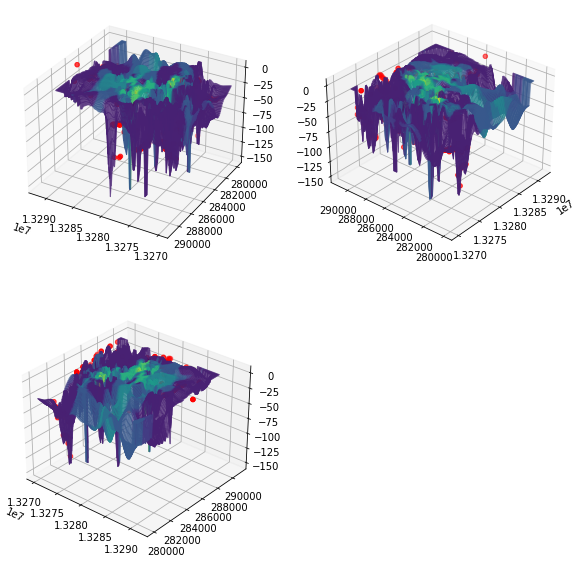

In [14]:
main(datetime.datetime(2016, 1, 1), datetime.datetime(2021, 12, 31), xrange = (13270000.0, 13290000.0),
         yrange = (280000.0, 290000.0), scatter = True, debug = False)

[-114.6062162162162, -94.85666666666667, -94.78399999999999, -89.61, -84.13961165048543, -83.81634146341464, -83.67743243243244, -82.22011363636365, -81.87191780821918, -79.25247863247864, -78.34471698113207, -78.07290598290595, -77.81827956989248, -77.31204081632653, -76.79974358974358, -76.74545454545455, -76.25681818181819, -75.83966386554623, -75.45949999999999, -75.02174825174826, -75.0057627118644, -74.97098591549296, -73.7446511627907, -73.51647887323945, -73.32479452054794, -73.27468085106382, -73.14408163265306, -72.89, -72.72200000000001, -72.49102362204725, -72.40666666666667, -72.34476190476191, -72.26953125, -71.86489361702128, -71.58630573248408, -71.52148148148149, -71.385, -70.71978723404254, -70.71921875000001, -70.17136363636362, -70.17107843137255, -70.16272727272728, -69.9843181818182, -69.94779661016948, -69.89339805825243, -69.76492063492064, -69.65047619047618, -68.80508620689653, -68.0371, -67.902890625, -67.8221138211382, -66.815, -66.59575757575759, -66.454259

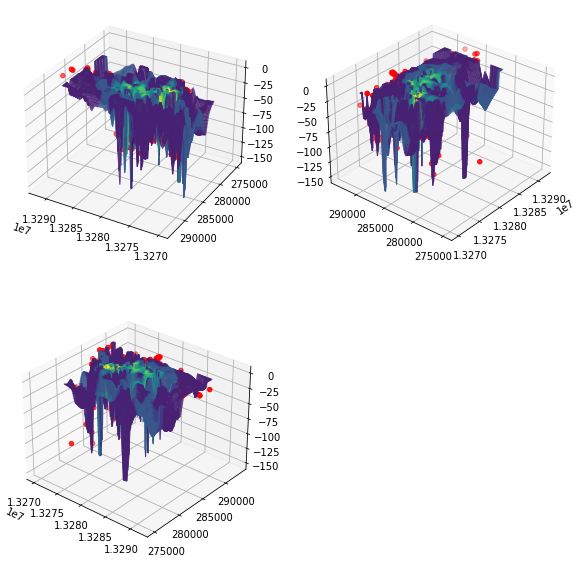

In [15]:
main(datetime.datetime(1986, 1, 1), datetime.datetime(2021, 12, 31), xrange = (13270000.0, 13290000.0),
         yrange = (280000.0, 290000.0), scatter = True, debug = False)

[-69.89339805825243, -63.3732258064516, -63.34860759493671, -60.30008333333333, -59.267096774193554, -57.84508771929824, -55.82636363636363, -55.634477611940305, -54.501, -53.26134615384615, -46.083636363636366, -45.40228571428571, -44.32530303030303, -42.69087378640778, -40.34412280701755, -40.10318181818182, -40.01492063492063, -38.71854838709677, -37.208125, -36.982089552238804, -36.02172413793104, -35.601683168316825, -35.214285714285715, -35.055142857142854, -34.648142857142844, -34.214285714285715, -33.93333333333334, -31.530538461538455, -31.384545454545457, -31.25023529411764, -31.234, -31.129489795918367, -29.611222222222224, -29.55263888888889, -28.81320754716981, -26.163623188405793, -23.790833333333335, -22.073611111111116, -21.841481481481484, -21.29125, -19.52225, -18.708787878787877, -16.749340659340664, -14.613333333333332, -14.570140845070423, -11.904848484848486, -11.467794117647061, -10.382692307692308, -9.682884615384616, -9.656470588235294, -9.38907894736842, -9.29

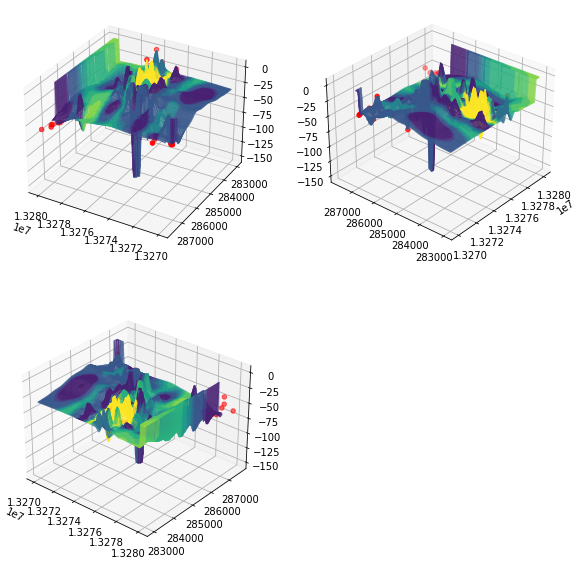

In [18]:
main(datetime.datetime(1986, 1, 1), datetime.datetime(1991, 12, 31), xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0), scatter = True, debug = False)

[-133.5, -127.0, -100.0, -97.5, -92.0, -92.0, -90.0, -88.0, -87.0, -87.0, -80.2, -80.0, -66.5, -64.0, -62.33, -62.0, -62.0, -61.0, -60.0, -60.0, -58.0, -58.0, -57.47, -57.29, -57.0, -57.0, -52.0, -50.5, -49.75, -46.0, -46.0, -46.0, -45.0, -44.0, -39.0, -39.0, -37.1, -34.0, -28.0, -23.0, -23.0, -20.0, -20.0, -19.5, -17.67, -16.0, -15.5, -15.0, -14.0, -12.0, -11.0, -8.0, -7.87, -7.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[ 1.32728290e+07  2.85907000e+05 -1.33500000e+02]
 [ 1.32745110e+07  2.85598000e+05 -1.27000000e+02]
 [ 1.32763458e+07  2.85337370e+05 -1.00000000e+02]
 ...
 [ 1.32795000e+07  2.86400000e+05 -7.26350775e+01]
 [ 1.32795000e+07  2.86600000e+05 -7.87157496e+01]
 [ 1.32795000e+07  2.86800000e+05 -8.27726657e+01]]
<class 'numpy.ndarray'>
[[-53.73816514 -53.69575009 -53.65361765 ...          nan          nan
           nan]
 [-53.71976564 -53.67650214 -53.63388225 ...          nan          nan
           nan]
 [-53.70175892 -53.6575416  -53.61387559 ...          nan          nan
       

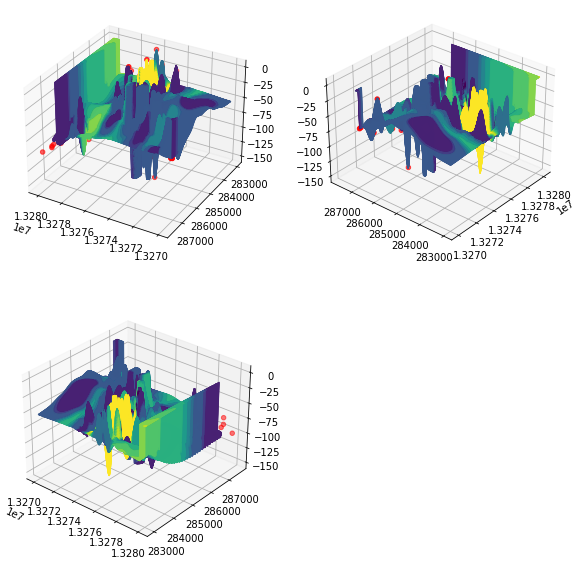

In [23]:
main(datetime.datetime(1986, 1, 1), datetime.datetime(1991, 12, 31), xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0), scatter = True, debug = False)